In [0]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
#import BlackjackEnv
#import plotting

matplotlib.style.use('ggplot')

In [0]:
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg- dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  ffmpeg

E: Unable to locate package libjpeg
E: Unable to locate package dev
E: Package 'libav-tools' has no installation candidate


In [0]:
!pip install pyvirtualdisplay
!pip install piglet

     |████████████████████████████████| 71kB 2.2MB/s 
     |████████████████████████████████| 92kB 4.6MB/s 


In [0]:
!pip install gym['all']

     |████████████████████████████████| 450kB 2.9MB/s 
     |████████████████████████████████| 122kB 13.1MB/s 
     |████████████████████████████████| 215kB 12.9MB/s 
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-9el9vvam/mujoco-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-9el9vvam/mujoco-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-qmjm0hk7/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


## BlackJack

In a game of Blackjack,

**Objective**: Have your card sum be greater than the dealers without exceeding 21.

All face cards are counted as 10, and the ace can count either as 1 or as 11.

**States**:

current sum (12-21)

dealer's showing card (ace, 2-10)

do I have a usable ace?

Reward: +1 for winning, 0 for a draw, -1 for losing (not discount)

Actions: stick (stopping receiving cards), hit (receive another card)

Policy: stick if my sum is 20 or 21, else hit

If the player holds an ace that he could count as 11 without going bust, then the ace is said to be usable.

Dealer's fixed strategy
STICK if  >=  17

HIT if  <  17

Outcome:
if  >  21  =>  LOSE

CLOSEST to 21  =>  WIN

EQUALLY CLOSE  =>  DRAW

To play Blackjack, a player obtains cards that total as close to 21 without going over. Face cards (K, Q, J) are each worth ten points. An Ace can be counted as either 1 or 11 points. If 11, it’s considered a **usable ace**.
if 1, it's considered a **no usable ace**.

Off Policy MC Control with Weighted Importance Sampling

In [0]:
env = gym.make('Blackjack-v0')

##Algorithm
**Importance Sampling**

Importance sampling plays a key role in sampling inferencing and reinforcement learning RL. In RL, importance sampling estimates the value functions for a policy π with samples collected previously from an older policy π’. In simple term, calculating the total rewards of taking an action is very expensive. However, if the new action is relatively close to the old one, importance sampling allows us to calculate the new rewards based on the old calculation.

In specific, with the Monte Carlo method in RL, whenever we update the policy θ, we need to collect a completely new trajectory to calculate the expected rewards.

A trajectory can be hundreds in steps and it is awfully inefficient for one single update. With importance sampling, we just reuse the old samples to recalculate the total rewards. However, when the current policy diverges from the old policy too much, the accuracy decreases. Therefore, we do need to resync both policies regularly.

![off-policy](https://miro.medium.com/max/1400/1*q1Et3CPekpwsC8rDIQjfFQ.png)


 Let’s look at the algorithm in more detail. We generate episodes using behavioral policy action which is an ε-greedy policy which means that with probability ε, it chooses an action uniform randomly and with probability 1-ε, it chooses the greedy action. This ensures the exploration of previously unexplored state-action values.
But, how are we using episodes generated from behavior policy to update our Q-values which are supposed to follow the greedy target policy? This is where the idea of importance sampling comes in.


 In off-policy methods, these two functions are separated. The policy used to generate behavior, called the behavior policy, may, in fact, be unrelated to the policy that is evaluated and improved, called the target policy. Although in principle, the behavior policy can be unrelated to the target policy, but in practice, it is kept quite representative of the target policy.

The relative probability of the trajectory under the target and behavior policies is:
![Probability](https://miro.medium.com/max/1400/1*chfRpr5FqcEI7JPRz4TvnQ.png)
### Importance Sampling


![sampling](https://miro.medium.com/max/1400/1*iwqOvsRMR9IPZ4SN36LHjA.png)

τ(s) in the equation below denotes the set of all time steps in which state s is visited.

Hence, the above equation is a simple average of all the returns weighted by the importance sampling ratios.
Note that the above average is unbiased, i.e. its expectation is Vπ(s). But the variance of this estimator is in general unbounded because the variance of the ratios can be unbounded. Because of this issue of unbounded variance, generally, another estimator called weighted importance sampling, which uses a weighted average, is strongly preferred over ordinary importance sampling.

### Weighted Importance Sampling

![weight](https://miro.medium.com/max/1400/1*YY1e1vo3PO6AOZFrF5R0Wg.png)

Although this estimator is biased (its expectation is Vb(s)), but if we assume bounded returns, then the variance of the weighted importance-sampling estimator converges to zero. In practice, the weighted estimator usually has a dramatically lower variance than ordinary importance sampling. Also note that the behavior policy is considered very representative of the target policy and hence in practice, the bias doesn’t lead to any adverse effects.

The above equation can be rewritten in the following way where G1, G2 … and so on are a sequence of returns, all starting in the same state and where each Wi is the importance sampling ratio.

![weight](https://miro.medium.com/max/754/1*4LGFFmH5zQCRcKefIlkXog.png)

In [0]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [0]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

In [0]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
        
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discount_factor * G + reward
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula (5.7)
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the behavior policy is not the action 
            # taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./behavior_policy(state)[action]
        
    return Q, target_policy

In [0]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=10000, behavior_policy=random_policy)

Episode 10000/10000.

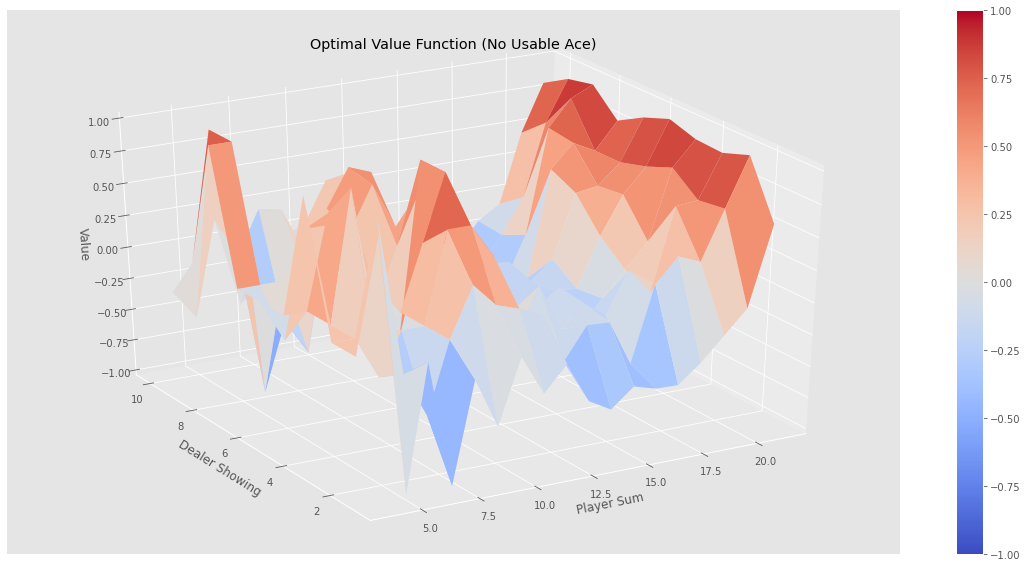

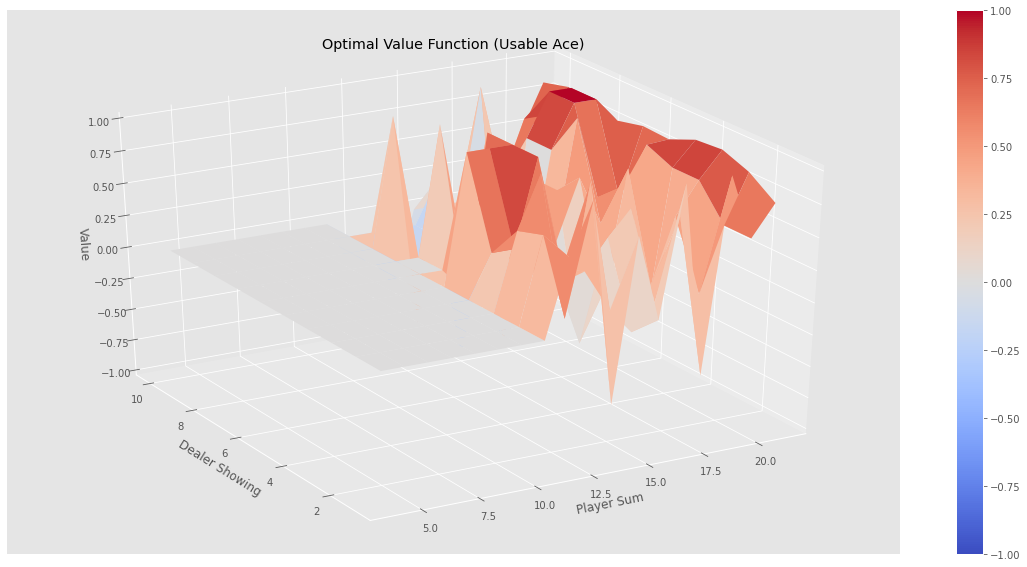

In [0]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function")

In [0]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

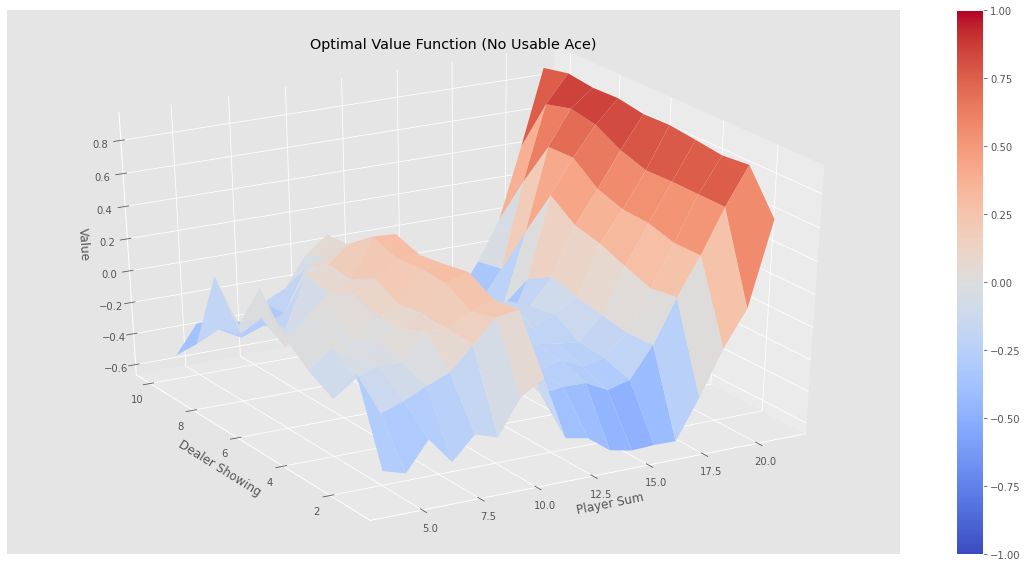

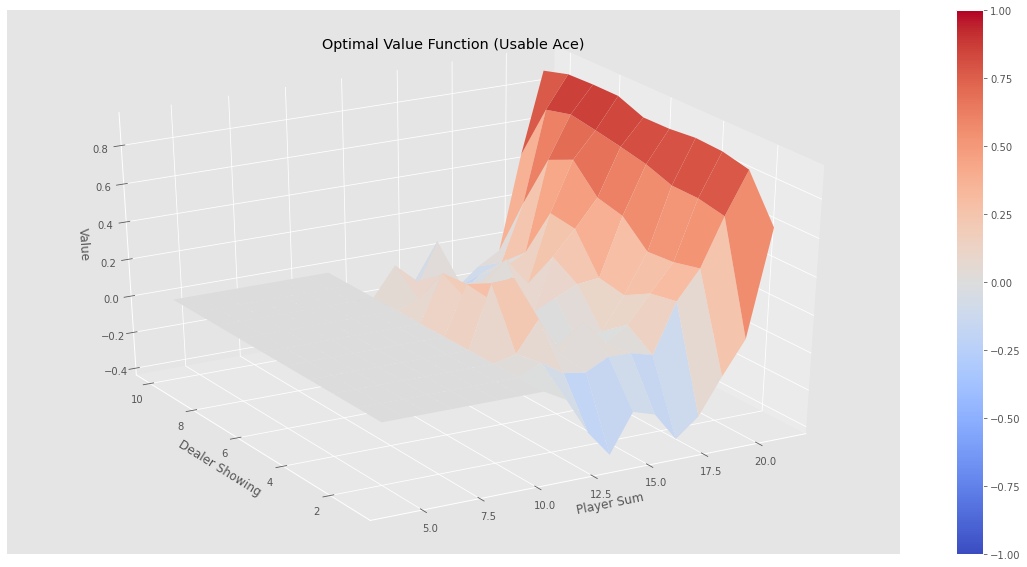

In [0]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function")

In [0]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3